# LBBB detection from ECG using SVM algorithm and through Daubechies 4 wavelet transform

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import os

### Loading the LBBB ECG signal for testing (Bitalino)

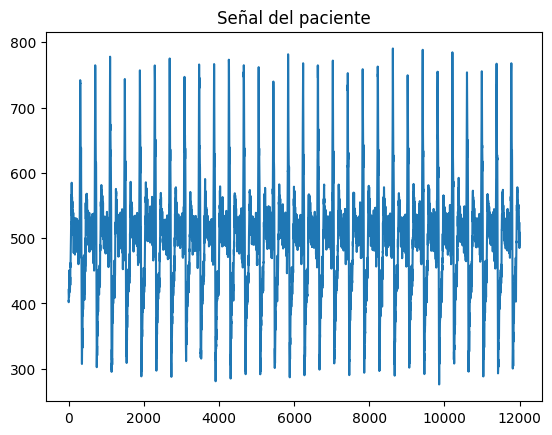

In [83]:
'''
directory = 'C:\\Users\\Alessandra\\Documents\\2023-1\\Introduccion a Señales Biomedicas\\Proyecto\\DATA_LBBB_test_Bitalino'

for file in os.listdir(directory):
    if file.endswith(".mat"):
        file_path = os.path.join(directory,file)
        data = sio.loadmat(file_path)
#loaded_data is a list and data is a dict

ecg_bitalino = data["ecg_lbbb_downsampled_by2"]
ecg_bitalino = ecg_bitalino[0:12000]
data_frame_leadI = pd.DataFrame(ecg_bitalino) #Creo un data frame del numpy array data_Ilead_util
    # Guardo el dataframe como un csv file
filename = f"LeadI_LBBB_test_Bitalino.csv"
data_frame_leadI.to_csv(filename, index=False)

    #2. Visualizacion en el tiempo (la comentare para evitar su ejecucion)
plt.plot(ecg_bitalino);plt.title("Señal del paciente");
plt.show()
'''

<Figure size 640x480 with 0 Axes>

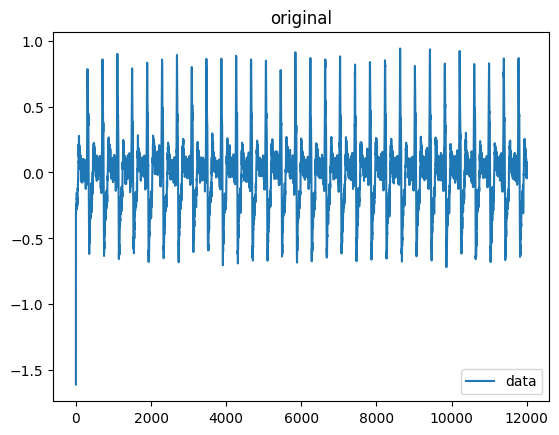

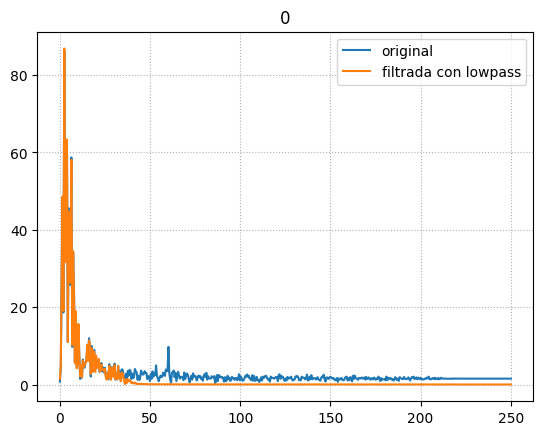

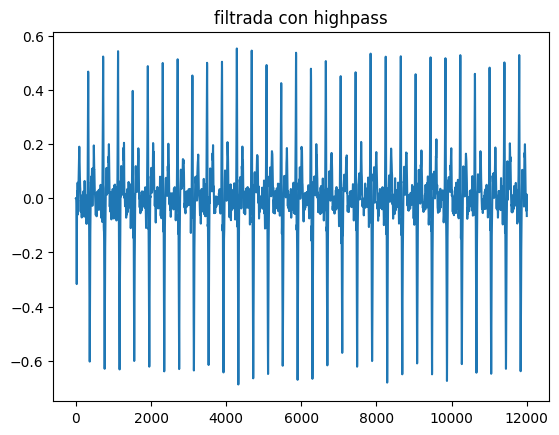

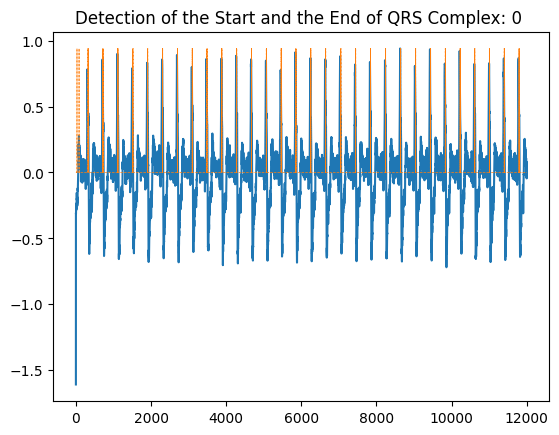

12001
12001


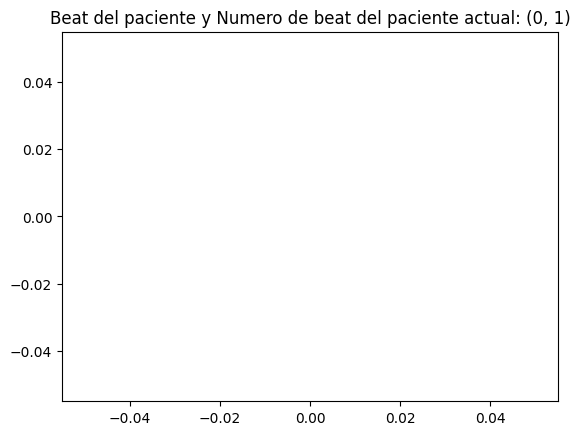

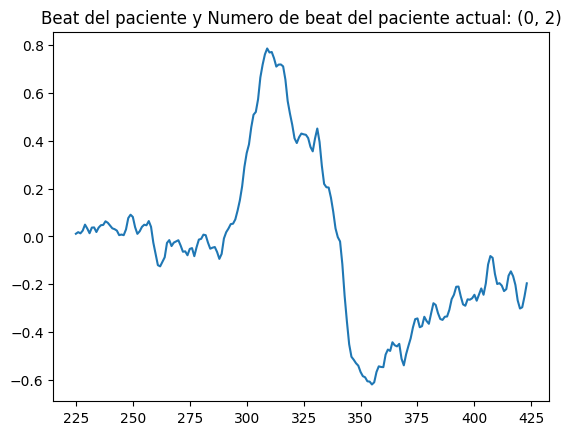

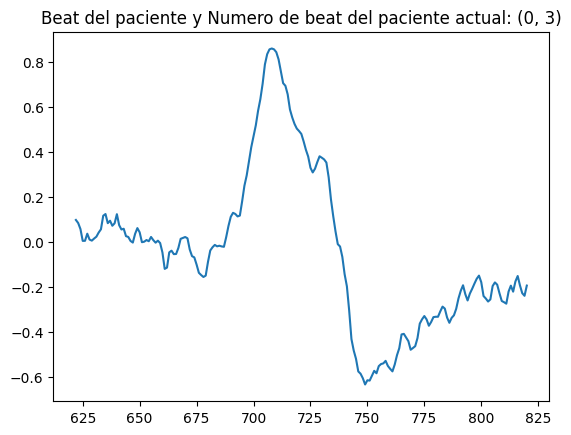

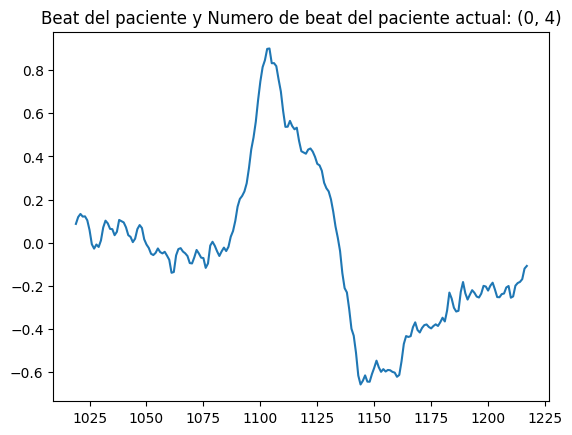

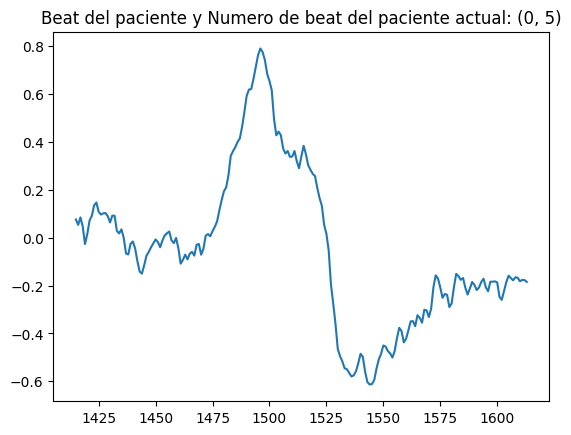

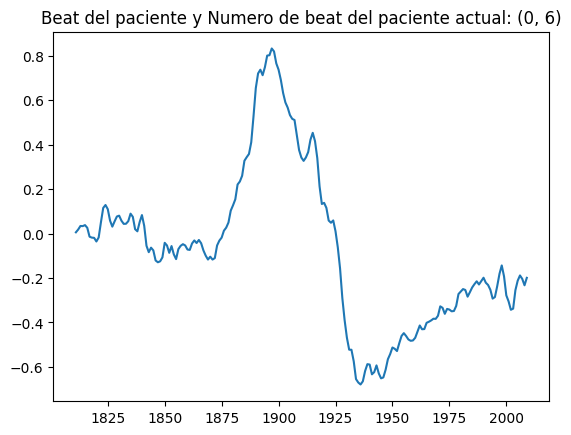

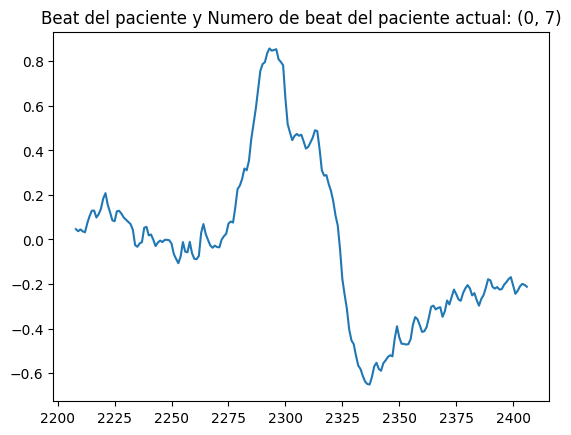

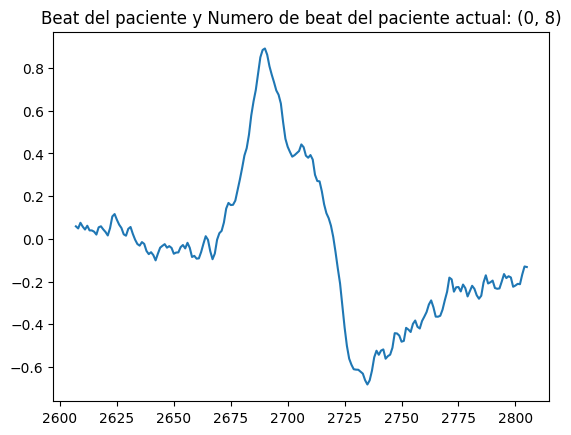

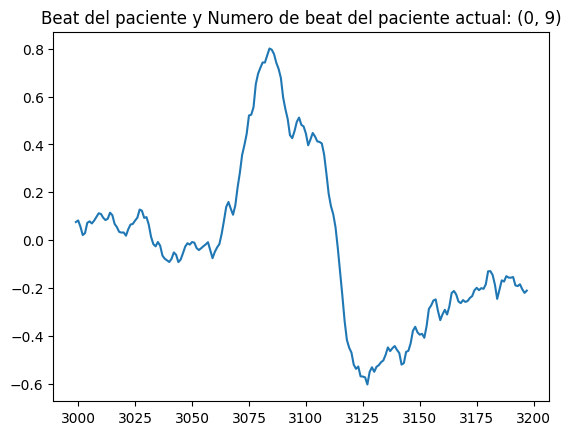

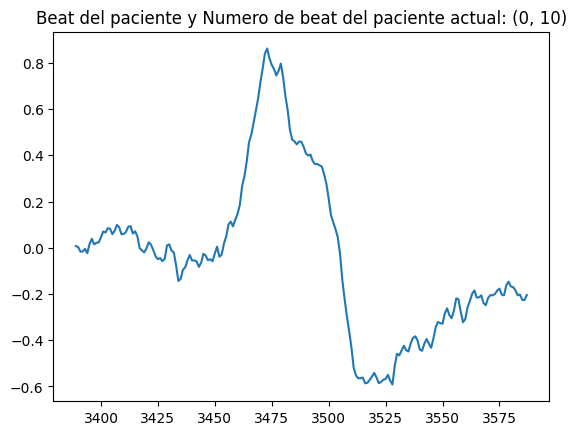

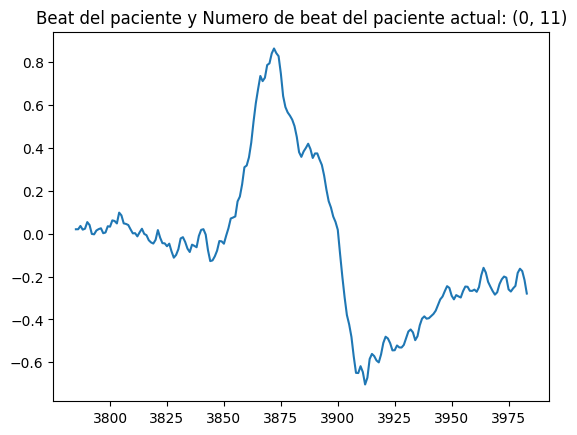

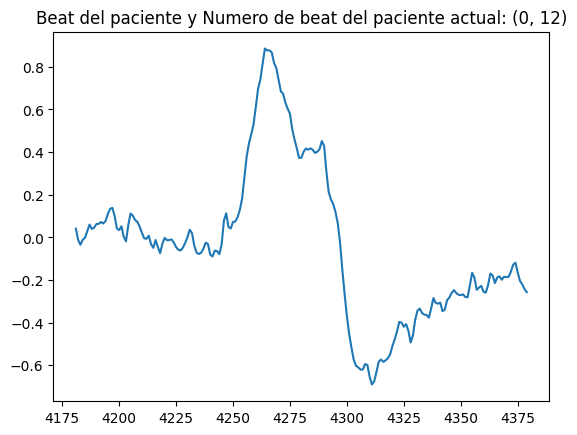

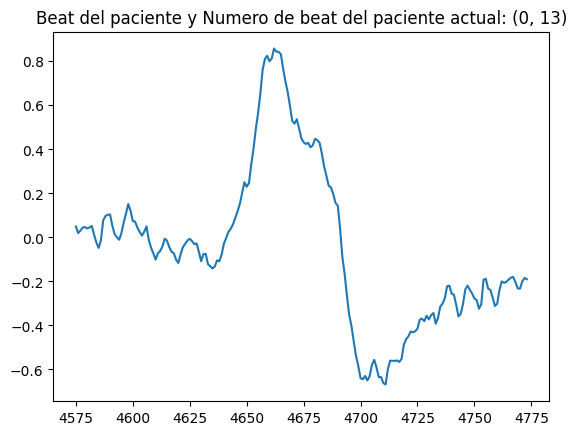

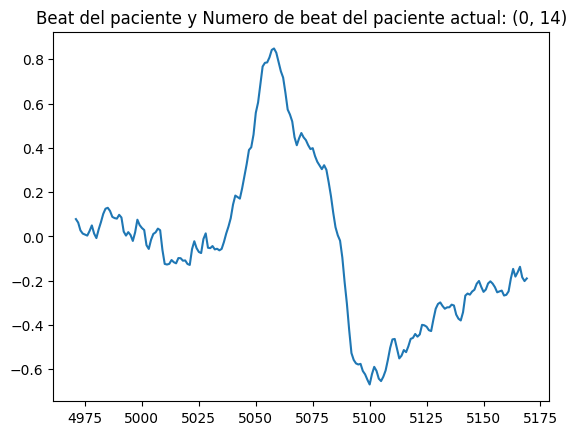

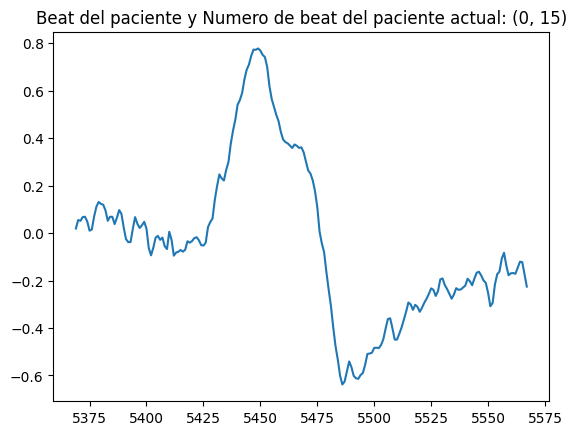

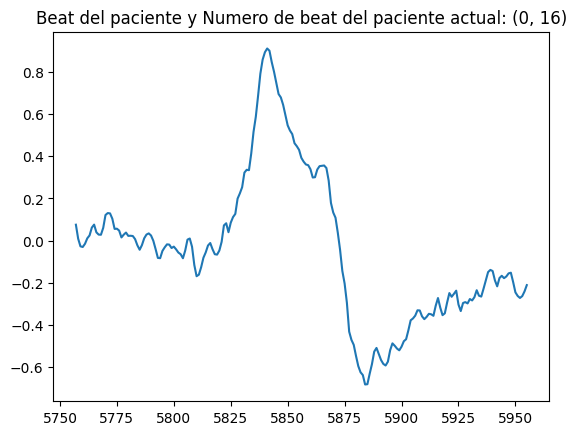

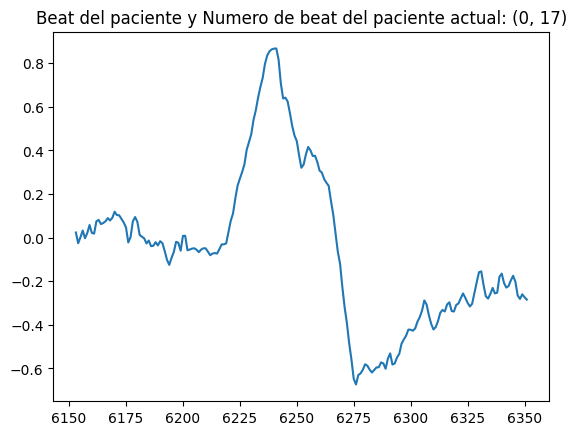

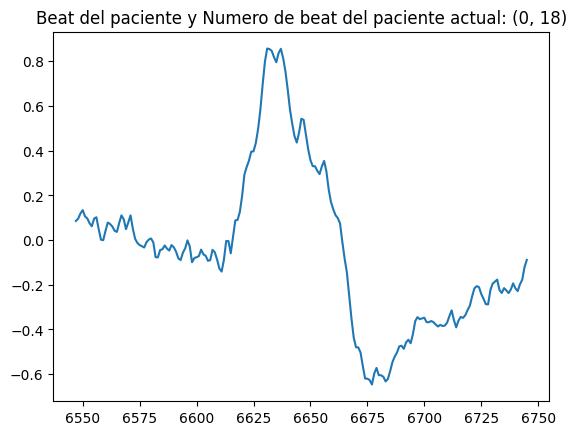

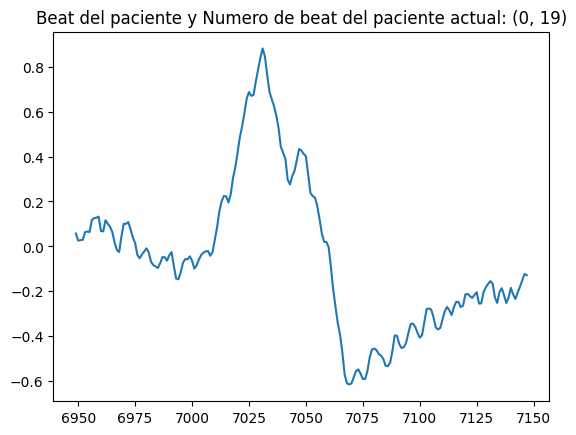

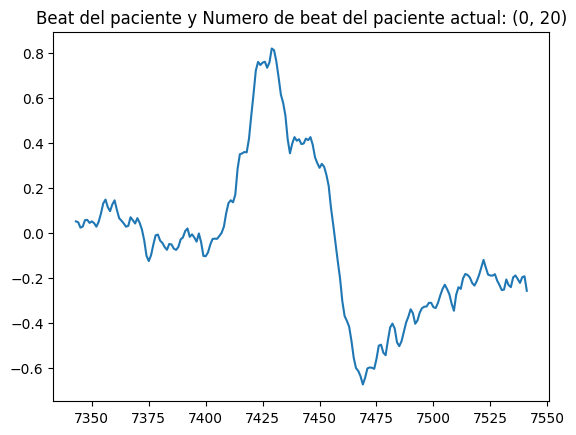

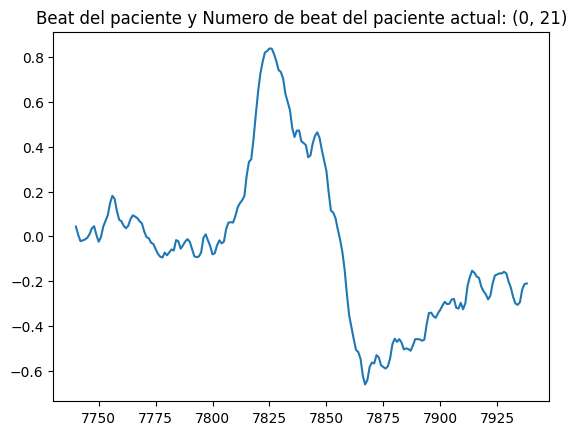

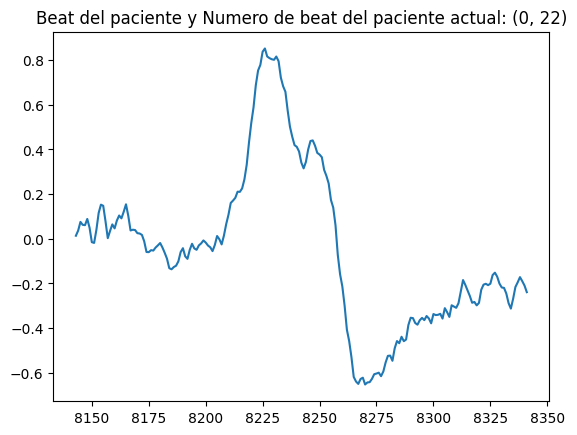

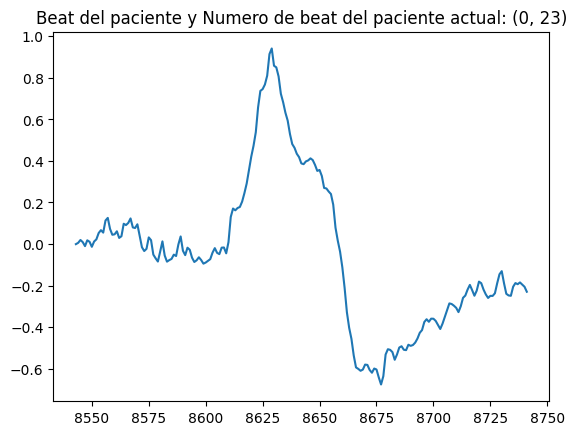

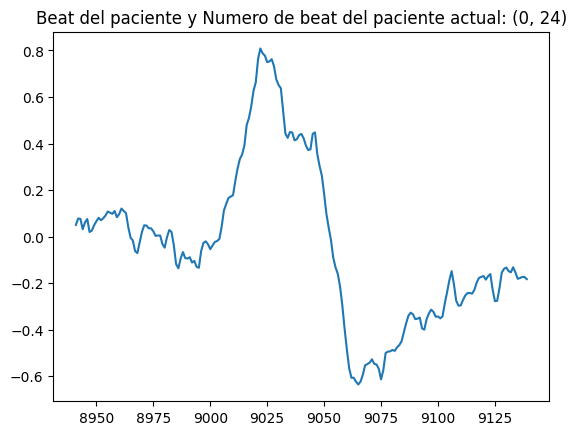

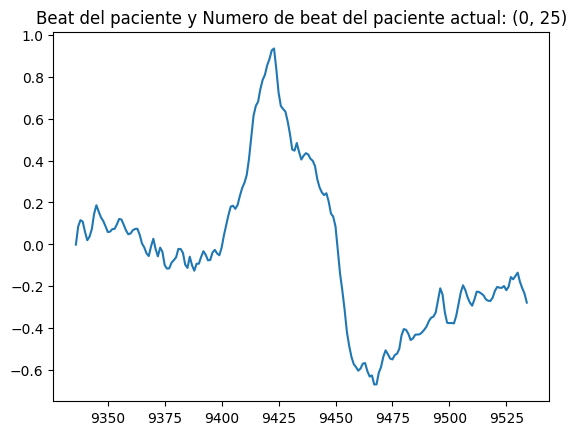

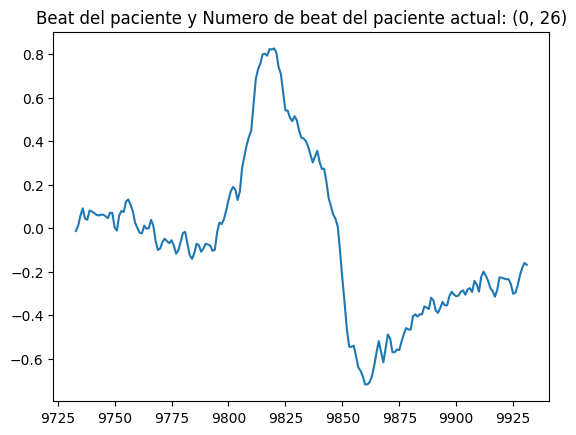

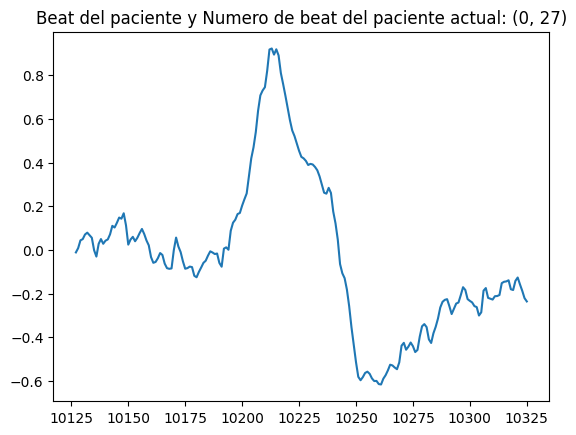

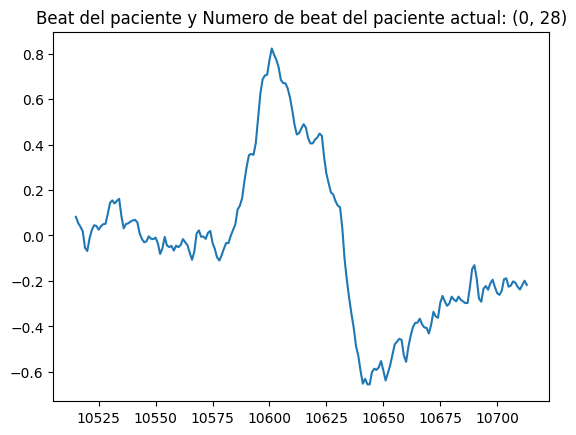

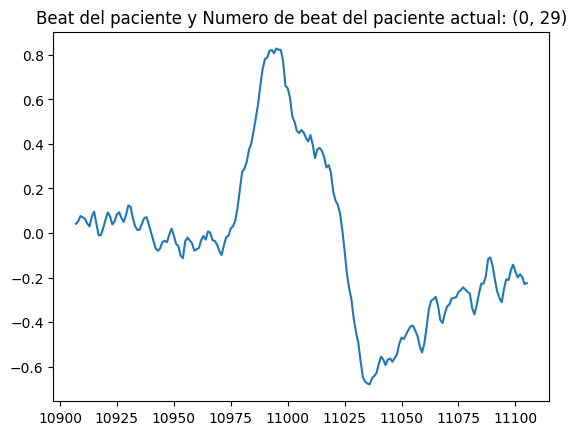

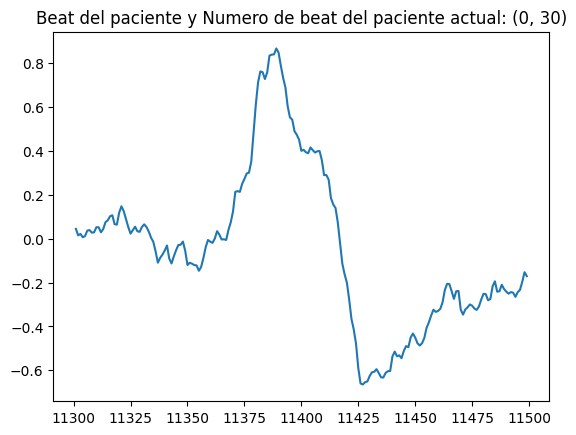

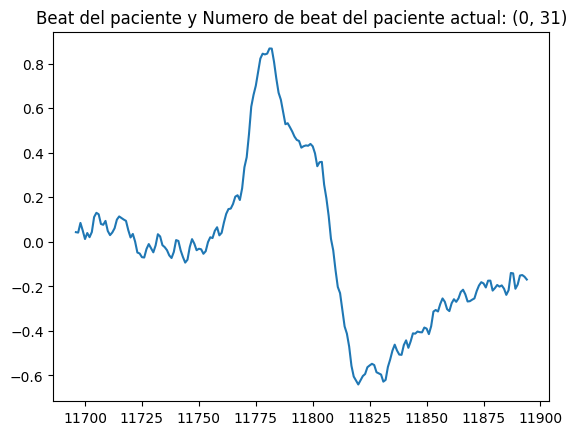

In [84]:
import zipfile
from scipy.fft import fft
from scipy.signal import firwin, lfilter
from scipy.signal import freqz, iirdesign, iirfilter, find_peaks, buttord, butter

beats_leadI = np.array([])
viables = 0;
dict_beats_leadI = {}
zip_lbbb_leadI = 'LeadI_LBBB_Bitalino.zip'
cont = 0
with zipfile.ZipFile(zip_lbbb_leadI, 'r') as archive:
    file_names = archive.namelist()
    # Iterando entre los files
    for file_name in file_names:
        if file_name.endswith('.csv'):
            archive.extract(file_name) # Extrayendo el file del archivo
            # Read the extracted CSV file using pd.read_csv
            leadI = pd.read_csv(file_name,names = ["data"])
            leadI.data = leadI.data - np.mean(leadI.data) # retiro el componente DC
            leadI.data = leadI.data*(3.3/1023) #resolucion*Vref/1023 segun el puerto A2 para ECG
            
            #leadI.head()
            
            t = np.arange(len(leadI))/500; #Sampling frequency: 500 Hz
            
            plt.figure()
            leadI.plot(); plt.title(cont);plt.title("original");
            
            Fs = 500; N = 1024;
            LEADI_fft = np.fft.fft(leadI.data,N)
            LEADI_fft = LEADI_fft[0:(N//2)]
            LEADI_fft = np.round(np.abs(LEADI_fft),3)
            FHz = np.linspace(0, Fs/2, N//2)
            #plt.figure()
            #plt.plot(FHz,LEADI_fft)
            
            """ DENOISING OF THE SIGNALS """
            
            """ Lowpass filtering """
            wp = 35; ws = 50 ; gpass = 3; gstop = 40;
            N_butt, Wn_butt = buttord(wp, ws, gpass, gstop, fs = Fs)
            b_butt, a_butt = butter(N_butt, Wn_butt, btype = 'lowpass', fs = Fs)
            #b = np.array([1.445060776485539e-07, 1.734072931782647e-06,9.537401124804557e-06, 3.179133708268186e-05, 7.153050843603419e-05, 0.0001144488134976547,0.0001335236157472638,0.00011444881349765471,7.153050843603419e-05, 3.1791337082681864e-05, 9.537401124804557e-06, 1.734072931782647e-06, 1.445060776485539e-07 ]) #con PyFDA
            #a = np.array([1, -7.094591978815702,23.737096019228055,-49.30600123514782, 70.59257921392032,-73.21410377119628, 56.29484980613934, -32.283844323032, 13.686797933361674, -4.178798849404314, 0.8713434520336844, -0.11131919782226472, 0.006584827629346309 ]) #con PyFDA
            leadI_filtered = lfilter(b_butt, a_butt,leadI.data)
            
            #plt.figure()
            #plt.plot(leadI_filtered);plt.title("filtrada con lowpass");
            #plt.show()
            
            LEADI_filtered_fft = np.fft.fft(leadI_filtered,N)
            LEADI_filtered_fft = LEADI_filtered_fft[0:(N//2)]
            LEADI_filtered_fft = np.round(np.abs(LEADI_filtered_fft),3)
            
            plt.figure()
            plt.plot(FHz,LEADI_fft,label = "original");plt.title(cont)
            plt.plot(FHz,LEADI_filtered_fft, label = "filtrada con lowpass")
            plt.legend()
            plt.grid(ls=":")
            
            """ Highpass filter """ #Para eliminar bajas frecuencias sin dañar el primer armonico
            b_high, a_high = iirfilter(1, 5.0, btype = 'highpass', rs=3, ftype = 'butter', fs = Fs)
            w_high, h_high = freqz(b_high, a_high, fs = Fs)
            leadI_signal_high = lfilter(b_high, a_high, leadI_filtered)
            plt.figure()
            plt.plot(leadI_signal_high);plt.title("filtrada con highpass");
            plt.show()
        

            """ R-PEAK DETECTION (QRS COMPLEX DETECTION): Pan-Tompkins algorithm """

            """ Derivative """
            b_der = np.array([-1, -2, 0, 2, 1]);
            b_der = (1/8)*b_der;
            w_der, h_der = freqz(b_der, 1, fs = Fs)
            #plt.figure(figsize=(10,5));    #Solo para visualizacion del filtro per se
            #plt.plot(w_der, 20 * np.log10(abs(h_der)), 'b')
            #plt.show()
            
            #Aplicacion del filtro derivativo
            fder_signal_leadI = lfilter(b_der, 1, leadI_filtered)
            #plt.figure(figsize=(20,5))
            #plt.plot(fder_signal_leadI);plt.title(f"ECG after Derivative filter: {cont}")
            #plt.show()
            
            """ Squaring function """
            f_sq_signal_leadI = np.square(fder_signal_leadI)
            #plt.figure(figsize=(20,5))
            #plt.plot(f_sq_signal_leadI);plt.title(f"ECG after Squaring function: {cont} ")
            #plt.show()

            """ Moving-Window Integration """ 
            #The purpose of moving-window integration is to obtain waveform feature information [from Pan-Tompkins: A Real-Time QRS Detection Algorith]
            N_mov_win = 75; #Numero de muestras en el ancho de la ventana de integracion. El ancho de la ventana debe ser aproximadamente la misma que el maximo ancho posible del complejo QRSshould be approximately the same as thewidest possible QRS complex.
            b_mov_win = np.ones(N_mov_win-1)
            b_mov_win = (1/N_mov_win)*b_mov_win
            f_mov_win_in_signal_leadI = lfilter(b_mov_win, 1, f_sq_signal_leadI)
            #plt.figure(figsize=(20,5))
            #plt.plot(f_mov_win_in_signal_leadI)
    
            """ Fiducial Mark """
            peaks_leadI, _ = find_peaks(f_mov_win_in_signal_leadI, distance = 100);#Required minimal horizontal distance (>= 1) in samples between neighbouring peaks.
            #plt.plot(peaks_leadI, f_mov_win_in_signal_leadI[peaks_leadI], "x");plt.title(f"ECG after Moving-Window Integration and Fiducial Marks: {cont} ")

            """ Adjusting the Tresholds """
            samples_leadI = len(peaks_leadI)
            th_I1_leadI = np.max(f_mov_win_in_signal_leadI[peaks_leadI[:samples_leadI]])*0.25
            th_I2_leadI = 0.5*np.mean(f_mov_win_in_signal_leadI[peaks_leadI[:samples_leadI]])
            #plt.hlines(th_I1_leadI, 0, len(f_mov_win_in_signal_leadI), colors='green')
            #plt.hlines(th_I2_leadI, 0, len(f_mov_win_in_signal_leadI), colors='red')
            #plt.show()  
            
            end_qrs_leadI = f_mov_win_in_signal_leadI > th_I1_leadI
            roll_qrs_r_leadI = np.roll(end_qrs_leadI, 1)
            roll_qrs_l_leadI = np.roll(end_qrs_leadI, -1)
            end_qrs_leadI = np.logical_xor(end_qrs_leadI ,roll_qrs_r_leadI)
            end_qrs_leadI = np.logical_and(end_qrs_leadI ,roll_qrs_l_leadI)
            #plt.figure(figsize=(20,5))
            #plt.xlim(0,1000)
            #plt.plot(leadI.data);plt.title("End of QRS Complex")
            #plt.plot(end_qrs_leadI*np.max(leadI.data))
            #plt.show()
            
            start_qrs_leadI = f_mov_win_in_signal_leadI < th_I2_leadI
            roll_qrs_l_leadI = np.roll(start_qrs_leadI, -1)
            roll_qrs_r_leadI = np.roll(start_qrs_leadI, 1)
            start_qrs_leadI = np.logical_xor(start_qrs_leadI ,roll_qrs_l_leadI)
            start_qrs_leadI = np.logical_and(start_qrs_leadI ,roll_qrs_r_leadI)
            #plt.figure(figsize=(20,5))
            #plt.plot(leadI.data);plt.title("Start of QRS Complex")
            #plt.xlim(0,1000)
            #plt.plot(start_qrs_leadI*np.max(leadI.data))
            #plt.show()
            
            QRS  = np.logical_or(start_qrs_leadI, end_qrs_leadI)
            plt.figure()
            plt.plot(leadI.data);plt.title(f"Detection of the Start and the End of QRS Complex: {cont} ")
            plt.plot(QRS*np.max(leadI.data),'--', linewidth = 0.5)
            plt.show()
            print(len(start_qrs_leadI))
            print(len(end_qrs_leadI))
            
            """ EXTRACTION OF BEATS """
            #Conversion from boolean array to int array
            start_qrs_leadI = 1*start_qrs_leadI
            end_qrs_leadI = 1*end_qrs_leadI
            
            #Finding indexes of start_qrs_leadI and end_qrs_leadI when equal to zero
            index_start_qrs_leadI = np.where(start_qrs_leadI == 1)[0]
            index_end_qrs_leadI = np.where(end_qrs_leadI == 1)[0]
            
            if len(index_start_qrs_leadI) == len(index_end_qrs_leadI):
                viables = viables+1
                #plt.figure()
                #plt.plot(leadI.data);plt.title(f"Detection of the Start and the End of QRS Complex: {cont} ")
                #plt.plot(QRS*np.max(leadI.data),'--', linewidth = 0.5)
                #plt.show()
                
                #Finding the "mean index" as the index of the R-wave
                index_r_wav_leadI = np.round((index_start_qrs_leadI + index_end_qrs_leadI)/2);
                index_r_wav_leadI = index_r_wav_leadI.astype(int)
                
                #print(cont, "lenght", len(index_start_qrs_leadI), index_start_qrs_leadI)
                #print(cont, "lenght", len(index_end_qrs_leadI), index_end_qrs_leadI)    
                #print(viables)
                #print("Indices de la Onda R",index_r_wav_leadI)
                
                cant_beats = 0;
                """ SEGMENTATION: Extraction of beats: 99 samples from R to the left and 100 samples from R to the right """
                for R in index_r_wav_leadI:
                    cant_beats = cant_beats + 1;
                    beat_leadI = leadI.data[R-99:R+100]
                    dict_beats_leadI[(cont, cant_beats)] = beat_leadI; #Creo un diccionario para almacenar todos los bits y luego eliminar los que no aporten infromacion relevante (realicé una inspeccion visual previamente a todos los beats)
                    plt.figure()
                    plt.plot(beat_leadI);plt.title(f"Beat del paciente y Numero de beat del paciente actual: {cont, cant_beats}")
                    plt.show()
            cont = cont + 1;

### LBBB beats

In [85]:
'''
keys_beats_leadI_eliminar = [(0,1)]
for key_leadI in keys_beats_leadI_eliminar:
    del dict_beats_leadI[key_leadI]

array_list_LBBB_beats_leadI_test = [] 

for key1_leadI, beat in dict_beats_leadI.items(): #Este for es solo para visualizar el resultado de mi segementacion
    #print(type(beat));#los values del dict son pandas.series
    array_beat_leadI = beat.values
    if len(array_beat_leadI) == 199:
        array_list_LBBB_beats_leadI_test.append(array_beat_leadI)
    #plt.plot(beat)
    #plt.title("Paciente y numero de beat" + str(key1_leadI))
    #plt.show()

array_LBBB_beats_leadI_test = np.array(array_list_LBBB_beats_leadI_test)

print("Numero total de beats utiles:",len(array_LBBB_beats_leadI_test), len(array_list_LBBB_beats_leadI_test)) #Finalmente, tenemos 818 beats utiles de 199 samples

#for i in array_LBBB_beats_leadI: #Es solo para visualizar que se almacenaron correctamente los beats
    #print(type(array_LBBB_beats_leadI)); #ambos son de type numpy.ndarray
    #print(type(i)); #ambos son de type numpy.ndarray
    #plt.plot(i)
    #plt.title("Paciente y numero de beat")
    #plt.show()

np.save('array_LBBB_beats_leadI_test_Bitalino_versionlarga.npy', array_LBBB_beats_leadI_test)
'''

Numero total de beats utiles: 30 30
